# 2.5 Graph Visualization Samples (Heterogeneous Ethereum Graph)

In this notebook, we visualize selected subgraphs of the heterogeneous Ethereum network.

Because the full graph is very large, we focus on *local ego-graphs* and *small induced subgraphs*:

- Ego subgraph of the highest-degree node  
- Ego subgraph around a token-transfer edge  
- Random induced subgraph  
- Ego subgraph around a high-PageRank node

These small visualizations help illustrate the structural patterns inside the heterogeneous graph.


## 1. Imports + Load Graph

We load the same heterogeneous graph `G` used in **2.4**.


In [3]:
import os
import sys
import random

import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = False  # visual graphs are cleaner without grids

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(PROJECT_ROOT)

print("PROJECT_ROOT:", PROJECT_ROOT)


PROJECT_ROOT: /Users/dada/Developer/italy_proj/DataMining/EhereumNetworkAnalysis


In [4]:
# Load the heterogeneous graph
HETERO_GRAPH_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "heterogeneous_graph.gpickle")

if not os.path.exists(HETERO_GRAPH_PATH):
    raise FileNotFoundError(
        f"Cannot find graph file at: {HETERO_GRAPH_PATH}\n"
        "Please save G in 2.3 using nx.write_gpickle()."
    )

with Path(HETERO_GRAPH_PATH).open("rb") as f:
    G = pickle.load(f)

print("Loaded heterogeneous graph G")
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Directed:", G.is_directed())



Loaded heterogeneous graph G
Nodes: 26447
Edges: 30638
Directed: True


## 2. Helper Functions for Subgraph Sampling and Visualization

We define two helper functions:

1. `sample_ego_subgraph`:  
   Extracts a radius-1 or radius-2 ego-graph around a given node, with an optional max-node limit.

2. `draw_hetero_subgraph`:  
   Visualizes the subgraph with nodes colored by `node_type`  
   and edges colored by `edge_type` (ETH, token, contract call).


In [5]:
def sample_ego_subgraph(G, center_node, radius=1, max_nodes=150):
    """
    Extract an ego-graph around a center node.
    If the ego graph is too large, randomly sample to keep at most max_nodes.
    """
    H = nx.ego_graph(G, center_node, radius=radius)
    
    if H.number_of_nodes() > max_nodes:
        # retain center + randomly sampled neighbors
        keep = {center_node}
        others = [n for n in H.nodes() if n != center_node]
        if len(others) > max_nodes - 1:
            others = np.random.choice(others, size=max_nodes - 1, replace=False)
        keep.update(others)
        H = H.subgraph(keep).copy()
        
    return H


def draw_hetero_subgraph(H, center_node=None, title=None):
    """
    Visualize a heterogeneous subgraph using node_type and edge_type.
    """
    # Node colors
    node_types = nx.get_node_attributes(H, "node_type")
    node_color_map = {
        "EOA": "tab:blue",
        "Contract": "tab:orange",
        "Token": "tab:green",
        "Unknown": "tab:gray",
    }

    node_colors = [
        node_color_map.get(node_types.get(n, "Unknown"), "tab:gray")
        for n in H.nodes()
    ]

    # Edge colors
    edge_types = nx.get_edge_attributes(H, "edge_type")
    edge_color_map = {
        "eth_transfer": "tab:gray",
        "token_transfer": "tab:red",
        "contract_call": "tab:purple",
    }

    edge_colors = []
    for u, v, k in H.edges(keys=True):
        et = edge_types.get((u, v, k), "Unknown")
        edge_colors.append(edge_color_map.get(et, "lightgray"))

    # Layout
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(H, k=0.35, iterations=50, seed=42)

    nx.draw_networkx_nodes(
        H, pos, node_color=node_colors, node_size=80, alpha=0.9
    )
    nx.draw_networkx_edges(
        H, pos, edge_color=edge_colors, alpha=0.7, arrows=False
    )

    # Highlight center node
    if center_node is not None and center_node in H:
        nx.draw_networkx_nodes(
            H, pos, nodelist=[center_node],
            node_size=200, node_color="yellow", edgecolors="black"
        )

    plt.axis("off")
    if title:
        plt.title(title)
    plt.show()


## 3. Ego Subgraph of the Highest-Degree Node

In many transaction graphs, the highest-degree address is either:
- a popular exchange deposit address, or  
- a frequently-used contract.

This visualization helps illustrate the local neighborhood structure around such a hub.


Highest-degree node: 0xdac17f958d2ee523a2206206994597c13d831ec7
Degree: 11228
Sampled subgraph: nodes = 1 , edges = 0


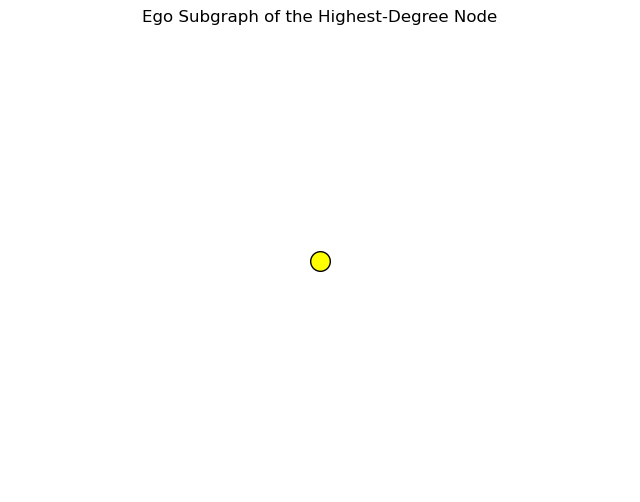

In [6]:
# Identify the highest-degree node
deg_dict = dict(G.degree())
max_deg_node, max_deg = max(deg_dict.items(), key=lambda x: x[1])

print("Highest-degree node:", max_deg_node)
print("Degree:", max_deg)

H_high = sample_ego_subgraph(G, max_deg_node, radius=1, max_nodes=150)

print("Sampled subgraph: nodes =", H_high.number_of_nodes(), ", edges =", H_high.number_of_edges())

draw_hetero_subgraph(H_high, center_node=max_deg_node, title="Ego Subgraph of the Highest-Degree Node")


## 4. Ego Subgraph around a Token-Transfer Edge

Token transfers represent interactions with ERC-20 smart contracts.  
We randomly select a token-transfer edge and visualize the local structure around one endpoint.


Number of token_transfer edges: 21418
Random token transfer edge: 0x3ea194ade8b9ff3b04f9b129fdbbf57d24444166 -> 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48
Subgraph nodes: 2 , edges: 1


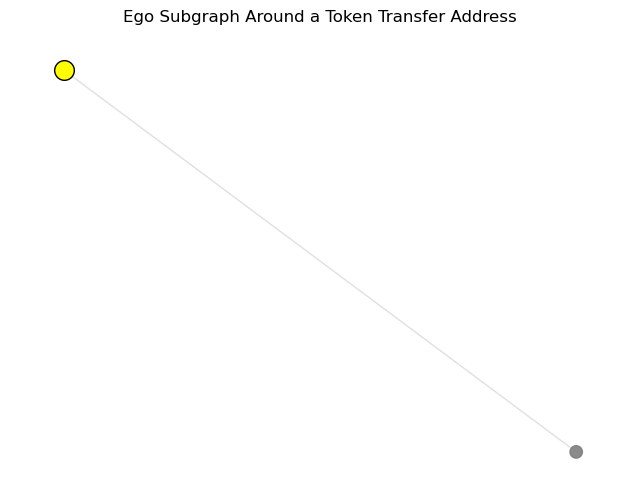

In [ ]:
# Identify token transfer edges
token_edges = [
    (u, v, k)
    for u, v, k, data in G.edges(keys=True, data=True)
    if data.get("edge_type") == "ETH_TRANSFER"   #TOKEN_TRANSFER   or ETH_TRANSFER
]

print("Number of token_transfer edges:", len(token_edges))

if len(token_edges) > 0:
    u, v, k = random.choice(token_edges)
    center = u  # choose one endpoint of the token-transfer

    print("Random token transfer edge:", u, "->", v)

    H_token = sample_ego_subgraph(G, center, radius=1, max_nodes=150)
    print("Subgraph nodes:", H_token.number_of_nodes(), ", edges:", H_token.number_of_edges())

    draw_hetero_subgraph(H_token, center_node=center, title="Ego Subgraph Around a Token Transfer Address")
else:
    print("No token transfer edges found.")
